In [1]:
"""
Check all datasets
"""
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
from ipywidgets import interact
from ipywidgets import Controller

import numpy as np
import sys
from tqdm import tqdm
import pandas as pd
sys.path.append('/export/home/asanakoy/workspace/neural_network')
sys.path.append('/export/home/asanakoy/workspace/art_datasets')
import make_data.dataset
import wikiart.info.preprocess_info
import art_datasets.read
from art_utils.pandas_tools import is_null_object


In [2]:
dfs = art_datasets.read.read_datasets()

artuk
artuk 207585
googleart
googleart 105965
moma
moma 25872
rijks
rijks 96189
wga
wga 35884
wiki
wiki 132302
meisterwerke
meisterwerke 19647
Total works count: 623444
time: 19.5 s


In [3]:
total_count = 0
for key, df in dfs.iteritems():
    total_count += len(df)
    print key, len(df)
print 'Total works count:', total_count

def browse_images(df):
    n = len(df)
    def view_image(i):
        obj = df.iloc[i].to_dict()
        if 'artist_name' not in obj:
            obj['artist_name'] = obj['artist_slug']
        else:
            print obj['artist_name']
#         print obj
        if is_null_object(obj['title']):
            obj['title'] = ''
        im = plt.imread(obj['image_path'])
        plt.imshow(im, interpolation=None)
        plt.title(unicode(obj['artist_name']) + u'; ' + obj['title'])
        plt.grid(False)
        plt.show()
    interact(view_image, i=(0, n-1))
# browse_images(dfs['rijks'])

wiki 132302
wga 35884
artuk 207585
meisterwerke 19647
googleart 105965
moma 25872
rijks 96189
Total works count: 623444
time: 24.3 ms


In [4]:
for key, df in dfs.iteritems():
    print key, df.columns
    print '==================='

wiki Index([     u'artist_slug',     u'artwork_slug',             u'date',
                  u'genre',         u'image_id',        u'image_url',
               u'keywords',            u'title',         u'page_url',
                  u'style',        u'technique',      u'description',
       u'location_created',            u'media',         u'location',
         u'list_of_styles',          u'century',      u'artist_name',
                   u'year',     u'artist_names',        u'years_bio',
        u'artist_url_wiki',      u'nationality',       u'image_path'],
      dtype='object')
wga Index([u'artist_name',   u'born-died',       u'title',   u'technique',
          u'location',         u'url',        u'form',       u'genre',
       u'nationality',    u'timeline',        u'year',   u'years_bio',
         u'artist_id',  u'image_path'],
      dtype='object')
artuk Index([u'artist_name', u'attribution', u'title', u'additional_title',
       u'medium', u'accesion_number', u'tags', u'years_bi

In [5]:
total_artists_num = 0
artist_names = list()
for key, df in dfs.iteritems():
    cur_artist_names = df.artist_name.unique().tolist()
    artist_names.extend(cur_artist_names)
    cur_artists_num = len(df.artist_name.unique())
    print key, 'unique artists:', cur_artists_num
    total_artists_num += cur_artists_num
print '--'
print 'Total unique artists num:', total_artists_num 
artist_names = np.unique(artist_names)
print len(artist_names)

wiki unique artists: 2277
wga unique artists: 3958
artuk unique artists: 36371
meisterwerke unique artists: 2294
googleart unique artists: 4446
moma unique artists: 3166
rijks unique artists: 4906
--
Total unique artists num: 57418
53131
time: 484 ms


In [36]:
df = dfs['wiki'][dfs['wiki']['artist_slug'] == 'jose-maria-velasco-gomez']
print df


Empty DataFrame
Columns: [artist_slug, artwork_slug, date, genre, image_id, image_url, keywords, title, page_url, style, technique, description, location_created, media, location, list_of_styles, century, artist_name, year, artist_names, years_bio, artist_url_wiki, nationality, image_path]
Index: []

[0 rows x 24 columns]
time: 18.3 s


In [7]:
df = dfs['wiki'][dfs['wiki']['artist_slug'] == 'jose-maria-velasco']
browse_images(df)

Widget Javascript not detected.  It may not be installed or enabled properly.


time: 428 ms


In [8]:
df1 = pd.DataFrame(columns=['x', '2', '1', '3'], data=np.zeros((1,4)))
df1

,x,2,1,3
0,0.0,0.0,0.0,0.0


time: 12.3 ms


In [9]:
df2 = pd.DataFrame(columns=['1', '2', 'a'], data=np.arange(9).reshape(3, 3))
df2

,1,2,a
0,0,1,2
1,3,4,5
2,6,7,8


time: 7.99 ms


In [10]:
df1.append(df2)

,1,2,3,a,x
0,0.0,0.0,0.0,NaN,0.0
0,0.0,1.0,NaN,2.0,NaN
1,3.0,4.0,NaN,5.0,NaN
2,6.0,7.0,NaN,8.0,NaN


time: 16.3 ms


In [25]:
def tta(image, n_crops=5, crop_size=224, full_image=True, fliplr=True, flipud=False):
    n_augs = (n_crops + full_image) * (1 + fliplr + flipud)
    assert image.shape[-1] == 3, image.shape
    augmented_images = np.zeros((n_augs, crop_size, crop_size, image.shape[-1]), image.dtype)

    idx = 0

    if full_image:
        augmented_images[idx, ...] = cv2.resize(image, (crop_size, crop_size))
        idx += 1

    assert (image.shape[0] - crop_size) % 2 == 0, (image.shape[0] - crop_size)
    offset = (image.shape[0] - crop_size) // 2
    offsets = [(offset, offset),  # central crop
               (0, 0), (0, 2 * offset),
               (2 * offset, 2 * offset), (2 * offset, 0)][:n_crops]

    for offset_row, offset_col in offsets:
        augmented_images[idx, ...] = image[offset_row:offset_row + crop_size,
                                     offset_col:offset_col + crop_size, ...]
        idx += 1

    cur_num_augs = idx
    for i in xrange(cur_num_augs):
        if fliplr:
            augmented_images[idx, ...] = np.fliplr(augmented_images[i, ...])
            idx += 1
        if flipud:
            augmented_images[idx, ...] = np.flipud(augmented_images[i, ...])
            idx += 1
    assert idx == len(augmented_images), '{} != {}'.format(idx, len(augmented_images))
    return augmented_images

time: 39.8 ms


In [12]:
import cv2

time: 11.6 ms


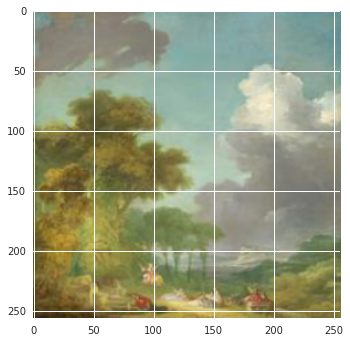

time: 277 ms


In [26]:
img = plt.imread(dfs['googleart'].iloc[123]['image_path'])
img_size = 256
img = np.asarray(cv2.resize(img, (img_size, img_size)))
plt.imshow(img)
plt.show()

1


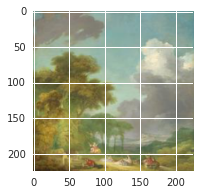

time: 232 ms


In [35]:
augmented_amages = tta(img, n_crops=0, crop_size=224, fliplr=False, flipud=False)
n = len(augmented_amages)
print n
plt.figure(figsize=(20, 10))
for i, aug_img in enumerate(augmented_amages):
    plt.subplot(3, 6, i + 1)
    plt.imshow(aug_img)
#     plt.grid(False)
plt.show()
# plt.axis(False)


In [15]:
1

1

time: 3.69 ms
